In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import load_disaster_point_data, load_synthetic_non_disaster_points, load_grid_point_data

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
from laos_gggi.data_functions.combine_data import load_all_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load

# from laos_gggi.transformers import CenterTransform, Standardize

configure_plot_style()

In [3]:
world = load_shapefile('world')
# rivers = load_rivers_data()
laos = world.query('ISO_A3 == "LAO"')

# Select SEA shape
laos_neighboors = ["LAO", "VNM", "KHM", "THA"]
sea_map = world.query('ISO_A3 in @laos_neighboors')

In [4]:
sea_point_grid = load_grid_point_data(region='sea', grid_size=100)
laos_point_grid = load_grid_point_data(region='laos', grid_size=100)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\sea_points_100.shp\sea_points_100.shp.shp
Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\laos_points_100.shp\laos_points_100.shp.shp


In [5]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip']]
co2 = all_data["df_time_series"]["co2"]

In [6]:
disasters = load_disaster_point_data()
not_disasters = load_synthetic_non_disaster_points(by='country', multiplier=3)

merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\synthetic_non_disasters_country_times_3.csv


In [7]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [8]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [9]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])

#Creating the squared log variables
df["log_population_density_squared"] = 2 * df["log_population_density"]
df["log_gdp_per_cap_squared"] = 2 * df["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [131]:
#Delimiting data set
columns_to_use = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'population_density',
               'gdp_per_cap', "lat", "long" , "geometry"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared', ]

model_df = df[ list( set( columns_to_use).union(set(features)) )].dropna()

laos_2020_data =  model_df.loc[lambda x:( x.ISO == "LAO") & (x.Start_Year == "2020")].iloc[0 ]
for feature in features:
    if feature not in laos_point_grid.columns:
        laos_point_grid[feature] = laos_2020_data[feature].item()

# Model helper functions

# Model on the full world data set

In [11]:
def add_data(features: list[str], target: str, df: pd.DataFrame , add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", df[features], dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
    return X,Y


def add_country_effect():
    with pm.modelcontext(None):
        country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
        country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
        country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
        country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")

    return country_effect, country_effect_mu, country_effect_scale, country_effect_offset


## 100% Sample m=15

# Creating sea grid

In [132]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df["ISO"]) 
obs_idx = model_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4_sample = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features,
        "gp_feature":gp_features }


In [133]:
import preliz as pz

with pm.Model(coords=coords_4_sample) as model_distance4:
    #Declare data
    X, Y= add_data(features= features ,  target = "is_disaster", df =  model_df, )
    is_island = pm.Data("is_island",  model_df["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])
    iso_idx_pt = pm.Data("iso_idx", ISO_idx, dims = ["obs_idx"] )

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", model_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell = pz.maxent(pz.LogNormal(), lower=0.5, upper=10.0 , mass= 0.94, plot= False).to_pymc(name = "ell", dims = ["gp_feature"])
    
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = country_effect[iso_idx_pt] + (X @ beta) + (is_island * is_island_beta) + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx', shape = X.shape[0])

In [123]:
sample_kwargs =  {"nuts_sampler": "nutpie", "nuts_sampler_kwrags": {"backend": "jax", "gradient_backend": "jax"  } }
model_distance4_idata = sample_or_load( fp = "full_sample_m15_long_non-dis_idata.idata", model =  model_distance4, sample_kwargs = sample_kwargs)

### Laos prediction

### Full model

In [136]:
with model_distance4.copy() as temp_model:
    pm.set_data({"X_gp": laos_point_grid[["lat", "lon"]],
                 "X": laos_point_grid[features],
                "iso_idx": np.full(laos_point_grid.shape[0], ISO.tolist().index("LAO") ),
                "is_island": np.full(laos_point_grid.shape[0], False ), 
                "Y": np.full(laos_point_grid.shape[0], 0 )},
                coords= {"obs_idx": laos_point_grid.index.values } )
    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))


from pymc.model.transform.optimization import freeze_dims_and_data

with freeze_dims_and_data(temp_model):
    HSGP_m_15_plot_idata = pm.sample_posterior_predictive(model_distance4_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

Sampling: []


Output()

In [42]:
#HSGP component
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

with pm.Model(coords=coords_4) as HSGP_m_15_plot:
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    f_plot_invlogit = pm.Deterministic('f_plot_invlogit', pm.math.invlogit(f_plot))

    HSGP_m_15_plot_idata = pm.sample_posterior_predictive(
        model_distance4_idata, var_names=["f_plot","f_plot_invlogit"]
    )
    

Sampling: []


Output()

In [43]:
#Store df of predictions
model_distance_HSGP_predictions = (HSGP_m_15_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["f_plot_invlogit"]
                               .to_dataframe())

#Merge predictions with Laos points
model_distance_HSGP_predictions = pd.merge(model_distance_HSGP_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
model_distance_HSGP_predictions_geo = gpd.GeoDataFrame(
                model_distance_HSGP_predictions,
    geometry=gpd.points_from_xy(model_distance_HSGP_predictions["lon"], model_distance_HSGP_predictions["lat"]), crs="EPSG:4326"
            )



In [44]:
#Create the geodata set for Laos disasters
laos_disasters = model_df.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

#Plot the predictions
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)
plt.title("HSGP for Laos", );

model_df.query('ISO == "LAO" & is_disaster == 1')

#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468")
plt.title("Predictions of the probability of disaster for Laos", )
;

### Full model predictions

az.summary(model_distance4_idata, var_names=["beta"])

In [45]:
#Full model predictions
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']


with pm.Model(coords=coords_4) as full_model_m_15_plot:
    #Declare data
    laos_is_island = laos_points["is_island"]
    laos_distances = laos_points[["log_distance_to_coastline", "log_distance_to_river"]]
    time_varying_features_2020 =(model_df.loc[70736,][time_varying_features]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    point_prediction = pm.Deterministic("point_prediction", 
                            country_effect[128] 
                            + ( is_island_beta * laos_is_island) 
                            #+ (beta[0] * laos_distances["log_distance_to_river"] ) + (beta[1] * laos_distances["log_distance_to_coastline"])
                            + f_plot
                            #+  (beta[2:] @ time_varying_features_2020 )
                              )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    full_model_m_15_plot_idata = pm.sample_posterior_predictive(
        model_distance4_idata, var_names= ["point_probability"]
    )
    

Sampling: []


Output()

In [46]:
#Store df of predictions
full_model_m_15_plot_idata_predictions = (full_model_m_15_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["point_probability"]
                               .to_dataframe())

#Merge predictions with Laos points
full_model_m_15_plot_idata_predictions = pd.merge(full_model_m_15_plot_idata_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
full_model_m_15_plot_idata_predictions_geo = gpd.GeoDataFrame(
                full_model_m_15_plot_idata_predictions,
    geometry=gpd.points_from_xy(full_model_m_15_plot_idata_predictions["lon"],
                                full_model_m_15_plot_idata_predictions["lat"]),crs="EPSG:4326"
            )



#Plot the predictions
fig, ax = plt.subplots()
full_model_m_15_plot_idata_predictions_geo.plot("point_probability",legend=True, ax=ax)
plt.title("Model prediction for Laos", );

#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468",markersize =5 )
plt.title("Predictions of the probability of disaster for Laos", )
;

# Estimation for southeast Asia only: HSGP

In [47]:
#We define the map and the df for south east asia
sea_df = model_df.query('ISO in @laos_neighboors')

#Tranform to geopandas df
sea_df = gpd.GeoDataFrame(sea_df,  geometry=gpd.points_from_xy(sea_df["long"],
                                sea_df["lat"]),crs="EPSG:4326")

To avoid centering problems, we need to have the same center values for `lat` and `long` in the `sea_df` and `sea_points` data frames.

In [48]:
print("Center for sea_df:")
print((sea_df[["lat", "long"]].max() - sea_df[["lat", "long"]].min() ) / 2)

print("-----------------------")

print("Center for sea_points:")
print((sea_points[["lat", "lon"]].max() -  sea_points[["lat", "lon"]].min()) /2)

Center for sea_df:
lat     8.791517
long    6.040052
dtype: float64
-----------------------
Center for sea_points:
lat    8.823740
lon    6.030132
dtype: float64


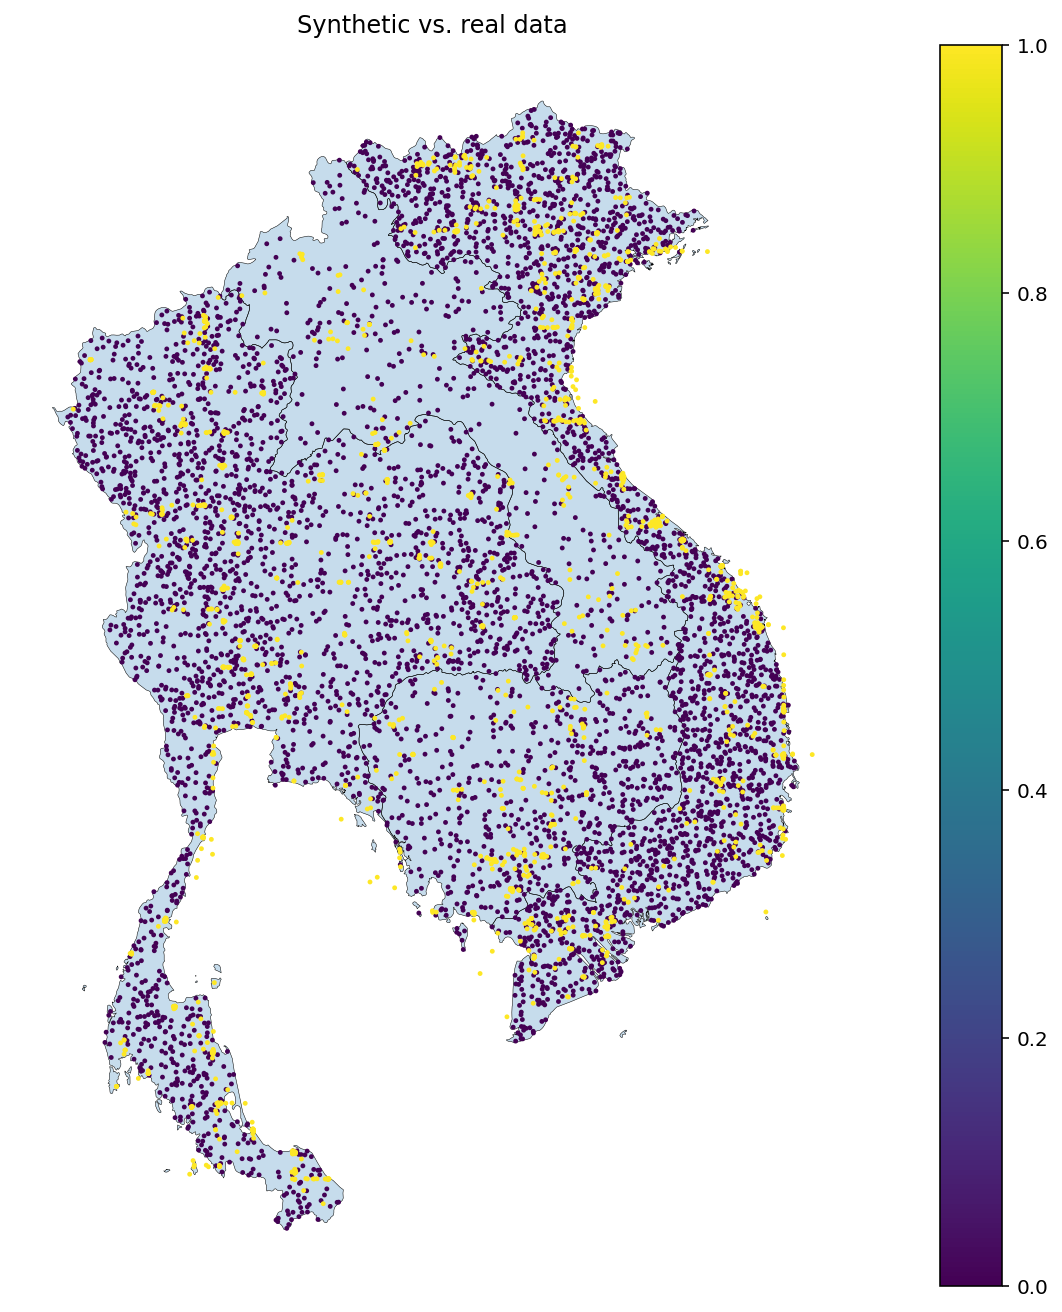

In [49]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @laos_neighboors').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

sea_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [50]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(sea_df["is_disaster"])
ISO_idx, ISO = pd.factorize(sea_df["ISO"]) 
obs_idx = sea_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(sea_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')



# Standardize data
transformer_stand_ =  Standardize().fit(sea_df)
sea_df_stand = transformer_stand_.transform(sea_df)

features_stand = []
for feature in features:
    features_stand.append(feature + "__standardized" )

#Set coords
coords_sea = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }


In [51]:
time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']
time_varying_features_stand = []

for feature in time_varying_features:
    time_varying_features_stand.append(feature + "__standardized")

In [73]:
with pm.Model(coords=coords_sea) as model_sea_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )
    is_island = pm.Data("is_island",  sea_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    # beta_sigma = [0.1] * 10
    # beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    # is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    
    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))


    #Model mu
    # p = (
    #     #country_effect[ISO_idx] + 
    #     (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    p = HSGP_component
    
    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')


In [59]:
if exists("model_sea_HSGP.idata"):
    model_sea_1_hsgp_idata = az.from_netcdf("model_sea_HSGP.idata")

else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_1_hsgp), backend="jax", gradient_backend='jax')
    model_sea_1_hsgp_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_sea_1_hsgp_idata = model_sea_1_hsgp_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_sea_1_hsgp_idata, filename= pathlib.Path("model_sea_HSGP.idata"))

In [74]:
with model_sea_1_hsgp:
    pm.set_data({"X_gp": laos_points[["lat", "lon"]] })

with freeze_dims_and_data(model_sea_1_hsgp):
    plot_data =  pm.sample_posterior_predictive(model_sea_1_hsgp_idata, var_names= ["HSGP_component"], compile_kwargs={"mode": "JAX"} )

Sampling: []


Output()

In [81]:
model_predictions = plot_data.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

#Merge predictions with Laos points
model_predictions= pd.merge(model_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

In [82]:
#Transform into geo Data Frame
model_predictions_geo = gpd.GeoDataFrame(
                model_predictions,
    geometry=gpd.points_from_xy(model_predictions["lon"],
                                model_predictions["lat"]),crs="EPSG:4326"
            )

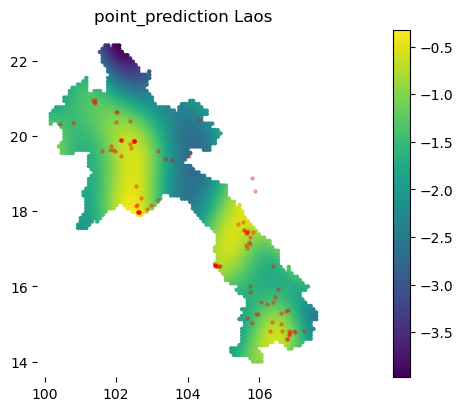

In [83]:
#Plot the predictions
fig, ax = plt.subplots()
model_predictions_geo.plot("HSGP_component",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction Laos", );

In [60]:
# HSGP predictions
# sea_grid_2d_basis = transformer__center.transform(sea_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
sea_grid_2d = np.array(sea_points[["lat", "lon"]])

with pm.Model(coords=coords_sea) as model_sea_hsgp_plot:
    #Declare data
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=sea_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    

    point_prediction =  pm.Deterministic("point_prediction", f_plot)
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_sea_hsgp_plot_idata = pm.sample_posterior_predictive(
        model_sea_1_hsgp_idata, var_names= ["point_prediction", "point_probability"]
    ) 

Sampling: []


Output()

In [56]:
#Store df of predictions
model_sea_hsgp_idata_predictions = {}
model_sea_hsgp_idata_predictions_geo = {}
for x in ["point_prediction", "point_probability"]:
    
    model_sea_hsgp_idata_predictions[x] = (model_sea_hsgp_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_sea_hsgp_idata_predictions[x] = pd.merge(model_sea_hsgp_idata_predictions[x], sea_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_sea_hsgp_idata_predictions_geo[x] = gpd.GeoDataFrame(
                    model_sea_hsgp_idata_predictions[x],
        geometry=gpd.points_from_xy(model_sea_hsgp_idata_predictions[x]["lon"],
                                    model_sea_hsgp_idata_predictions[x]["lat"]),crs="EPSG:4326"
                )

In [57]:
#Create the geodata set for sea disasters
sea_disasters = model_df.query('ISO in @laos_neighboors & is_disaster == 1')

sea_disasters_geo = gpd.GeoDataFrame(
                sea_disasters,
    geometry=gpd.points_from_xy(sea_disasters["long"], sea_disasters["lat"]), crs="EPSG:4326"
            )

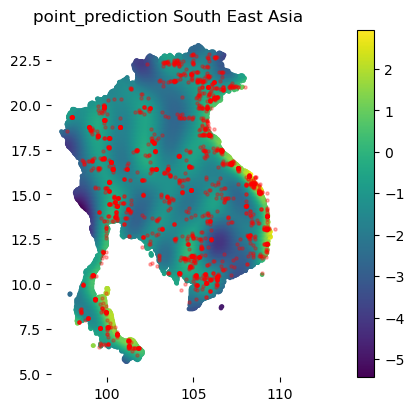

In [58]:
#Plot the predictions
fig, ax = plt.subplots()
model_sea_hsgp_idata_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction South East Asia", );

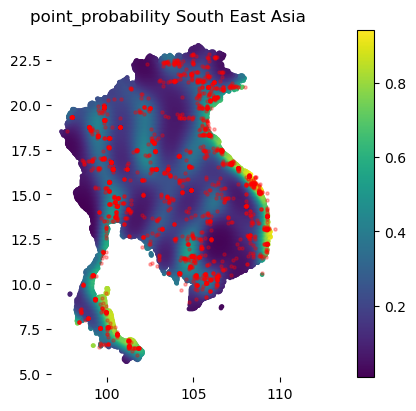

In [59]:
fig, ax = plt.subplots()
model_sea_hsgp_idata_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability South East Asia", );

# Estimation for southeast Asia only: Full model

We create the merged sea_points_extended for predictions

In [60]:
# Merge points with world ISO
sea_points_extended = gpd.sjoin(sea_points, sea_map, how="left", )

In [61]:
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

sea_points_extended = pd.merge(sea_points_extended, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

C:\Users\camil\AppData\Local\Temp\ipykernel_17292\459676040.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_4_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_17292\459676040.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_4_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_17292\459676040.py:4: FutureWa

In [62]:
with pm.Model(coords=coords_sea) as model_sea_full:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )
    is_island = pm.Data("is_island",  sea_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))


    #Model mu
    p = (
        country_effect[ISO_idx] + 
        (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    # p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [63]:
if exists("model_sea_full.idata"):
    model_sea_full_idata = az.from_netcdf("model_sea_full.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_full), backend="jax", gradient_backend='jax')
    model_sea_full_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_sea_full_idata = model_sea_full_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_sea_full_idata, filename= pathlib.Path("model_sea_full.idata"))

In [64]:
#Define cooords
ISO_predict_idx, ISO_predict = pd.factorize(sea_points_extended["ISO"]) 
obs_idx_predict = sea_points_extended.index


#Set coords
coords_sea["obs_idx_predict"] = obs_idx_predict
coords_sea["ISO_predict"] = ISO_predict

In [65]:
# HSGP predictions
sea_grid_2d = np.array(sea_points_extended[["lat", "lon"]])

with pm.Model(coords=coords_sea) as model_sea_full_plot:
    #Declare data
    sea_is_island = sea_points_extended["is_island"]
    sea_distances = sea_points_extended[["log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]]
    time_varying_features_2020 =np.array(sea_points_extended[time_varying_features_stand]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    country_effect = pm.Flat("country_effect", dims = ["ISO"])

    # HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=sea_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    

    point_prediction = pm.Deterministic("point_prediction", 
                         country_effect[ISO_predict_idx] 
                        + (is_island_beta * sea_is_island) 
                        + (beta[0] * sea_distances["log_distance_to_river__standardized"] ) + (beta[1] * sea_distances["log_distance_to_coastline__standardized"])
                        + f_plot
                        +  ( time_varying_features_2020 @ beta[2:])
                          )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_sea_full_plot_idata = pm.sample_posterior_predictive(
        model_sea_full_idata, var_names= ["point_prediction", "point_probability"]
    ) 

Sampling: []


Output()

In [66]:
#Store df of predictions
model_sea_full_predictions = {}
model_sea_full_predictions_geo = {}
for x in ["point_prediction", "point_probability"]:
    
    model_sea_full_predictions[x] = (model_sea_full_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_sea_full_predictions[x] = pd.merge(model_sea_full_predictions[x], sea_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_sea_full_predictions_geo[x] = gpd.GeoDataFrame(
                    model_sea_full_predictions[x],
        geometry=gpd.points_from_xy(model_sea_full_predictions[x]["lon"],
                                    model_sea_full_predictions[x]["lat"]),crs="EPSG:4326"
                )

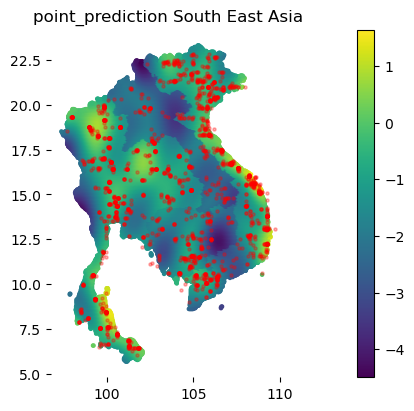

In [67]:
#Plot the predictions
fig, ax = plt.subplots()
model_sea_full_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction South East Asia", );

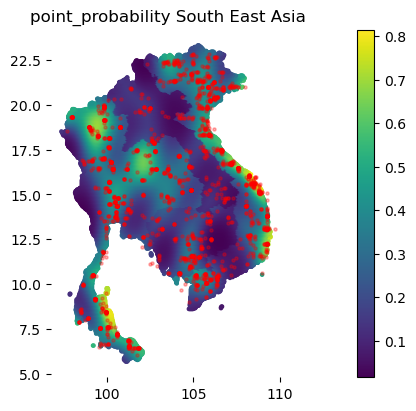

In [68]:
fig, ax = plt.subplots()
model_sea_full_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability South East Asia", );

# Estimation for Laos only: HSGP

In [69]:
#We define the map and the df for south east asia
laos_map = world.query('ISO_A3 == "LAO"')
lao_df = model_df.query('ISO == "LAO"')

#Tranform to geopandas df
lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

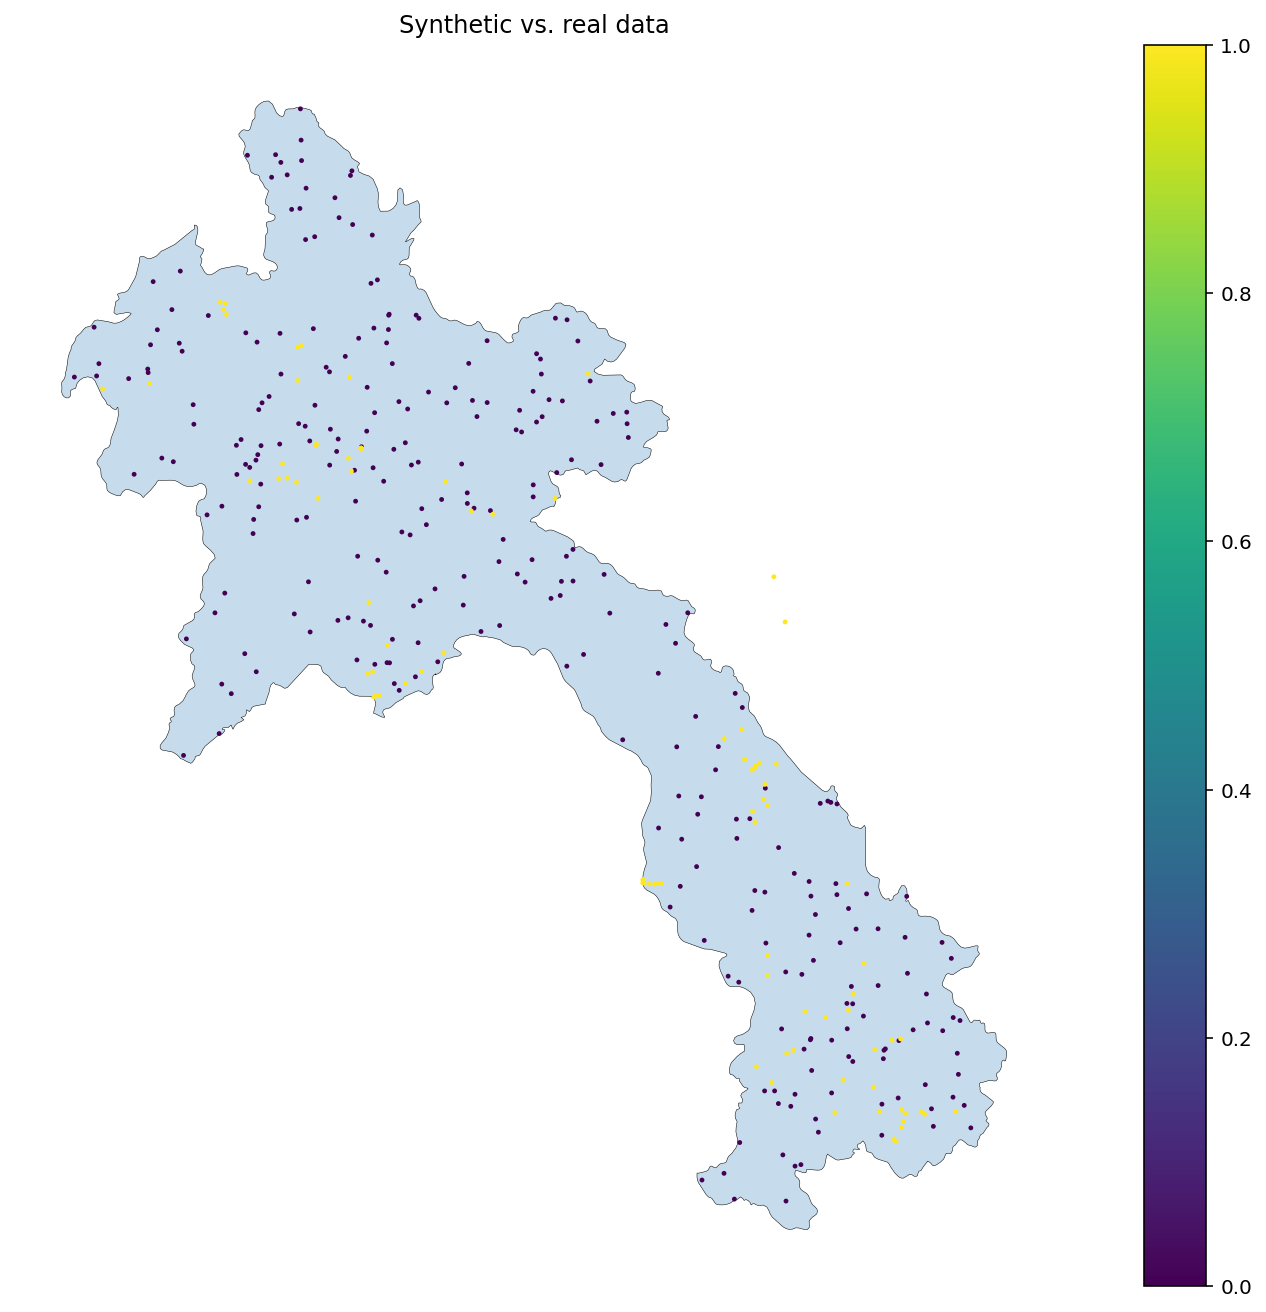

In [70]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
laos_map.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
laos_map.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)

lao_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [71]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(lao_df["is_disaster"])
ISO_idx, ISO = pd.factorize(lao_df["ISO"]) 
obs_idx = lao_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(lao_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

# Standardize data
transformer_stand_ =  Standardize().fit(lao_df)
lao_df_stand = transformer_stand_.transform(lao_df)

# Center the lat and long variables for the HSGP
transformer__center = CenterTransform().fit(lao_df[["lat", "long"]])
centered_HSGP_data = transformer__center.transform(lao_df[["lat", "long"]])

#Set coords
coords_lao = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }


In [72]:
with pm.Model(coords=coords_lao) as model_lao_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  lao_df_stand, )
    is_island = pm.Data("is_island",  lao_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    # beta_sigma = [0.1] * 10
    # beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    # is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", centered_HSGP_data)

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    # p = (
    #     #country_effect[ISO_idx] + 
    #     (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [73]:
from pymc.model.transform.optimization import freeze_dims_and_data

if exists("model_lao_1_hsgp.idata"):
    model_lao_1_hsgp_idata = az.from_netcdf("model_lao_1_hsgp.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_lao_1_hsgp), backend="jax", gradient_backend='jax')
    model_lao_1_hsgp_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_lao_1_hsgp_idata = model_lao_1_hsgp_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_lao_1_hsgp_idata, filename= pathlib.Path("model_lao_1_hsgp.idata"))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.19,31
,1300,0,0.18,31
,1300,0,0.18,31
,1300,0,0.18,31
,1300,0,0.18,31
,1300,0,0.19,31


In [74]:
#Full model predictions
laos_grid_2d_basis = transformer__center.transform(laos_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
laos_grid_2d = np.array(laos_grid_2d_basis)


with pm.Model(coords=coords_lao) as model_lao_1_hsgp_plot:
    #Declare data
    # laos_is_island = laos_points["is_island"]
    # laos_distances = laos_points[["log_distance_to_coastline", "log_distance_to_river"]]
    # time_varying_features_2020 =(lao_df_stand.loc[18901,][time_varying_features_stand]).astype(float)

    # #Flat variables
    # is_island_beta = pm.Flat("is_island_beta")
    # beta = pm.Flat("beta", dims = ["feature"])
    # country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    # point_prediction = pm.Deterministic("point_prediction", 
    #                          country_effect[0] 
    #                          + ( is_island_beta * laos_is_island) 
    #                         + (beta[0] * laos_distances["log_distance_to_river"] ) + (beta[1] * laos_distances["log_distance_to_coastline"])
    #                         + f_plot
    #                         +  (beta[2:] @ time_varying_features_2020 )
    #                           )
    point_prediction =  pm.Deterministic("point_prediction", f_plot)
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_lao_1_hsgp_plot_idata = pm.sample_posterior_predictive(
        model_lao_1_hsgp_idata, var_names= ["point_prediction", "point_probability"]
    )
    

Sampling: []


Output()

In [75]:
#Store df of predictions
model_lao_1_hsgp_idata_predictions = {}
model_lao_1_hsgp_idata_predictions_geo = {}

for x in ["point_prediction", "point_probability"]:

    
    model_lao_1_hsgp_idata_predictions[x] = (model_lao_1_hsgp_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_lao_1_hsgp_idata_predictions[x] = pd.merge(model_lao_1_hsgp_idata_predictions[x], laos_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_lao_1_hsgp_idata_predictions_geo[x] = gpd.GeoDataFrame(
                    model_lao_1_hsgp_idata_predictions[x],
        geometry=gpd.points_from_xy(model_lao_1_hsgp_idata_predictions[x]["lon"],
                                    model_lao_1_hsgp_idata_predictions[x]["lat"]),crs="EPSG:4326"
                )

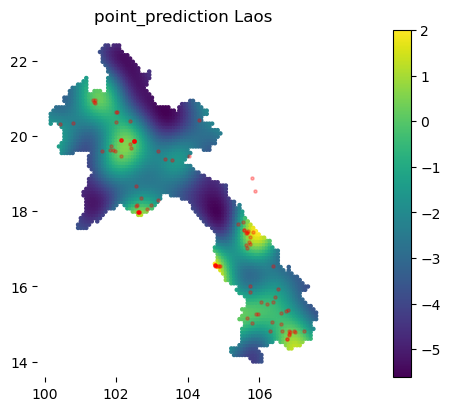

In [76]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_hsgp_idata_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction Laos", );

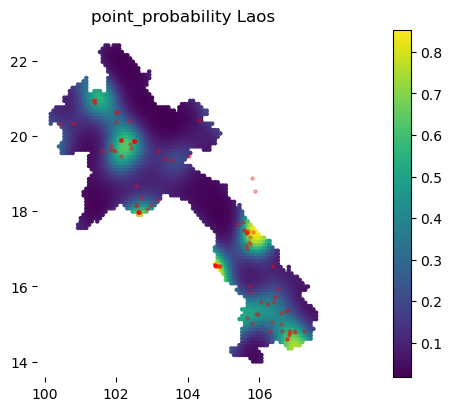

In [77]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_hsgp_idata_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability Laos", );

# Estimation for Laos only: Full model

In [78]:
#We define the map and the df for south east asia
laos_map = world.query('ISO_A3 == "LAO"')
lao_df = model_df.query('ISO == "LAO"')

#Tranform to geopandas df
lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

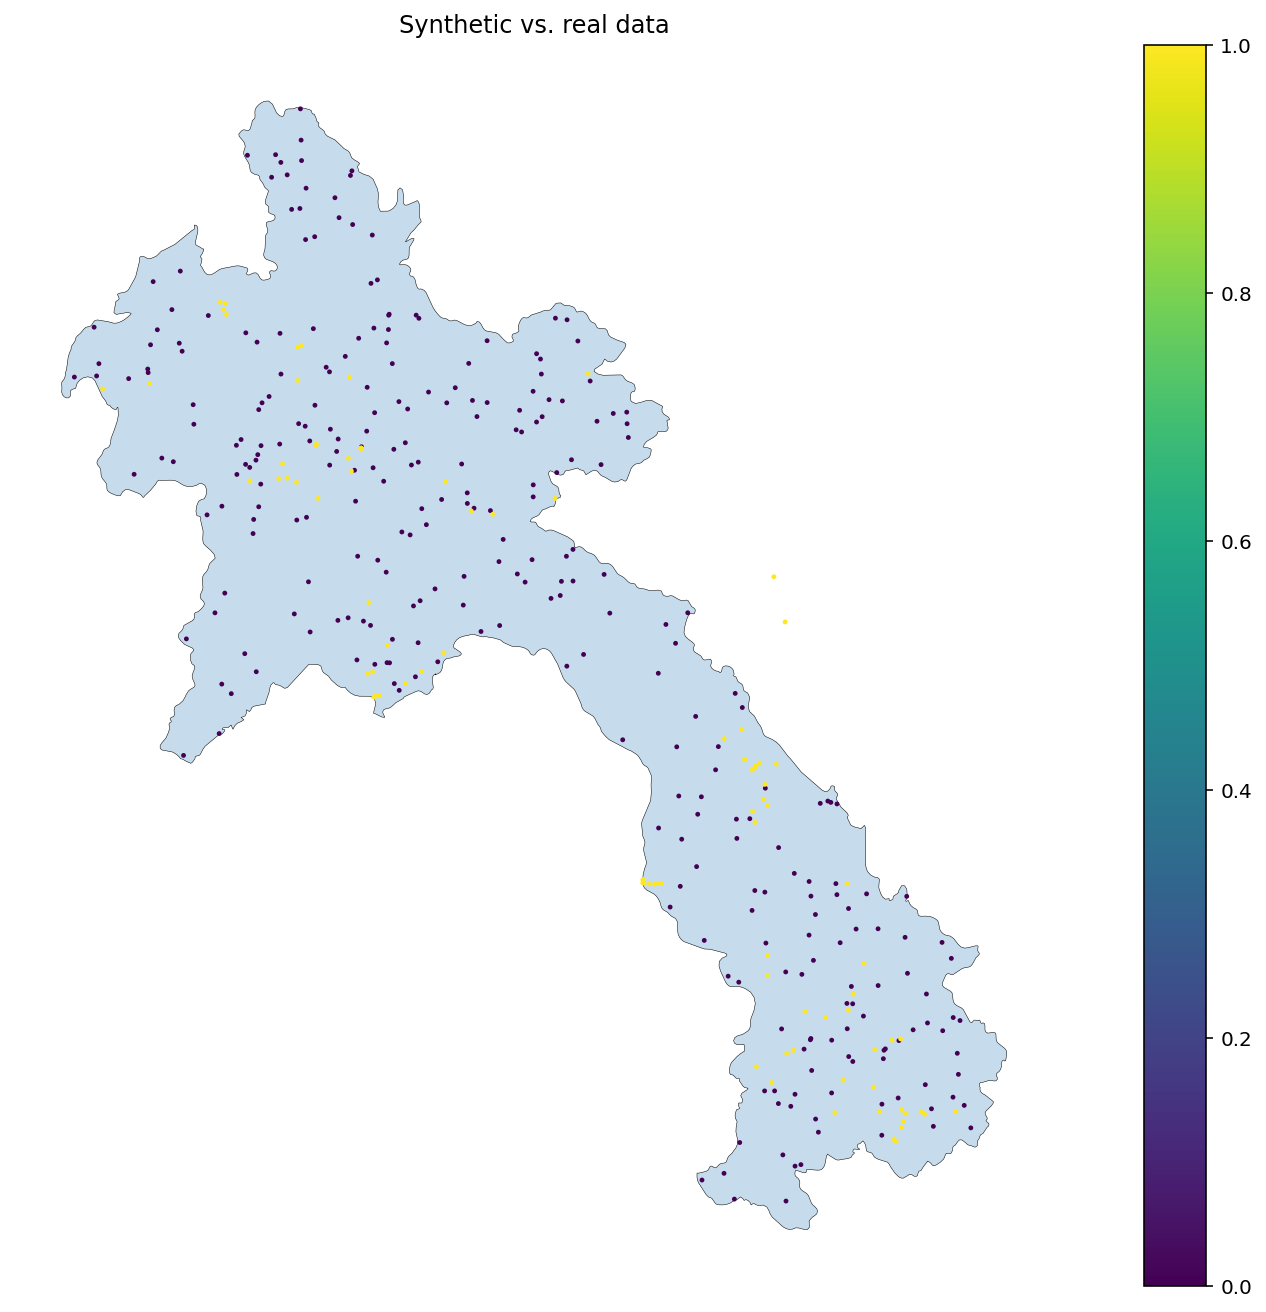

In [79]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
laos_map.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
laos_map.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)

lao_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [80]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(lao_df["is_disaster"])
ISO_idx, ISO = pd.factorize(lao_df["ISO"]) 
obs_idx = lao_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(lao_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')


# Standardize data
transformer_stand_ =  Standardize().fit(lao_df)
lao_df_stand = transformer_stand_.transform(lao_df)

# Center the lat and long variables for the HSGP
transformer__center = CenterTransform().fit(lao_df[["lat", "long"]])
centered_HSGP_data = transformer__center.transform(lao_df[["lat", "long"]])

#Set coords
coords_lao = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [81]:
with pm.Model(coords=coords_lao) as model_lao_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  lao_df_stand, )
    is_island = pm.Data("is_island",  lao_df["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", centered_HSGP_data)

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = (
        #country_effect[ISO_idx] + 
        (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    # p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [82]:
if exists("model_lao_full.idata"):
    model_lao_1_full_idata = az.from_netcdf("model_lao_full.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_lao_1_hsgp), backend="jax", gradient_backend='jax')
    model_lao_1_full_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_lao_1_full_idata = model_lao_1_full_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_lao_1_full_idata, filename= pathlib.Path("model_lao_full.idata"))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.19,31
,1300,0,0.17,31
,1300,0,0.19,31
,1300,0,0.18,31
,1300,0,0.19,31
,1300,0,0.19,31


In [83]:
#Full model predictions
laos_grid_2d_basis = transformer__center.transform(laos_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
laos_grid_2d = np.array(laos_grid_2d_basis)


with pm.Model(coords=coords_lao) as model_lao_1_hsgp_plot:
    #Declare data
    laos_is_island = laos_points["is_island"]
    laos_distances = transformer_stand_.transform(laos_points)[["log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]]
    time_varying_features_2020 =(lao_df_stand[time_varying_features_stand].loc[18901,]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    # country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    point_prediction = pm.Deterministic("point_prediction", 
                             # country_effect[0] 
                             ( is_island_beta * laos_is_island) 
                            + (beta[0] * laos_distances["log_distance_to_river__standardized"] ) + (beta[1] * laos_distances["log_distance_to_coastline__standardized"])
                            + f_plot
                            +  (beta[2:] @ time_varying_features_2020 )
                              )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_lao_1_full_plot_idata = pm.sample_posterior_predictive(
        model_lao_1_full_idata, var_names= ["point_prediction", "point_probability"]
    )
    

Sampling: []


Output()

In [84]:
#Store df of predictions
model_lao_1_full_predictions = {}
model_lao_1_full_predictions_geo = {}

for x in ["point_prediction", "point_probability"]:
    
    model_lao_1_full_predictions[x] = (model_lao_1_full_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_lao_1_full_predictions[x] = pd.merge(model_lao_1_full_predictions[x], laos_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_lao_1_full_predictions_geo[x] = gpd.GeoDataFrame(
                    model_lao_1_full_predictions[x],
        geometry=gpd.points_from_xy(model_lao_1_full_predictions[x]["lon"],
                                    model_lao_1_full_predictions[x]["lat"]),crs="EPSG:4326"
                )

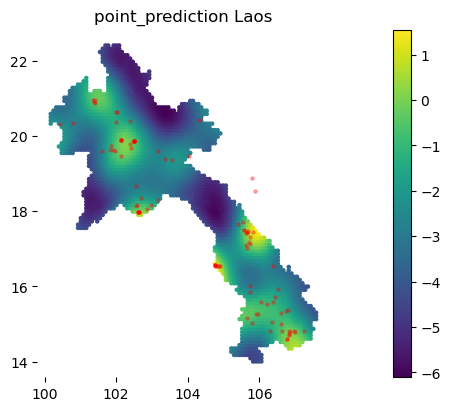

In [85]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_full_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction Laos", );

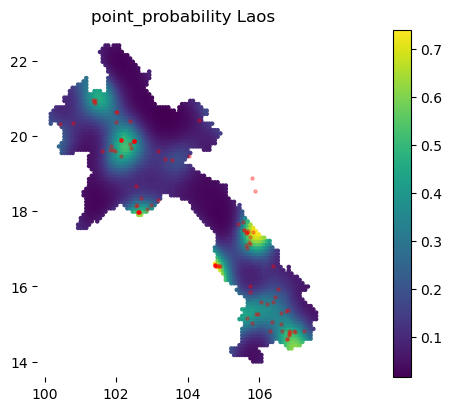

In [86]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_full_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability Laos", );